In [5]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [2]:
uploaded=files.upload()

Saving india-political-states-map.jpeg to india-political-states-map.jpeg


In [6]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray');

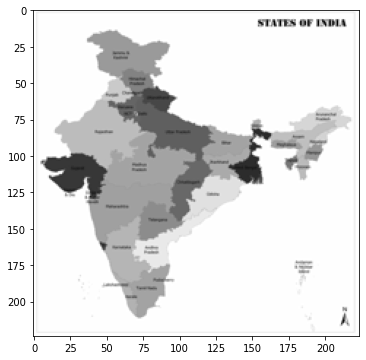

In [7]:
img = Image.open('/content/india-political-states-map.jpeg')
img = ImageOps.grayscale(img)
img = img.resize(size=(224, 224))
plot_image(img=img)

In [8]:
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

In [9]:

def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

In [10]:
calculate_target_size(img_size=224, kernel_size=3)

222

In [11]:
calculate_target_size(img_size=224, kernel_size=5)

220

Let’s work on a convolution function next. Here’s what a 3x3 filter does to a single 3x3 image subset:

Extracts it to a separate matrix
Does an element-wise multiplication between the image subset and the filter
Sums the results
Here’s an implementation in code for a single 3x3 pixel subset:

In [12]:
subset=np.array(img)[0:0+3,0:0+3]
subset

array([[254, 254, 254],
       [254, 254, 251],
       [254, 255, 236]], dtype=uint8)

In [13]:
np.multiply(subset,sharpen)

array([[   0, -254,    0],
       [-254, 1270, -251],
       [   0, -255,    0]])

In [14]:
np.sum(np.multiply(subset,sharpen))

256

The convolve() function calculates the target size and creates a matrix of zeros with that shape, iterates over all rows and columns of the image matrix, subsets it, and applies the convolution

In [15]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

Let’s test the thing. The following snippet applies the sharpening filter to our image:


In [16]:
img_sharpened = convolve(img=np.array(img), kernel=sharpen)
img_sharpened

array([[256., 264., 245., ..., 267., 255., 254.],
       [276., 199., 209., ..., 208., 274., 253.],
       [273., 210., 275., ..., 209., 273., 253.],
       ...,
       [274., 201., 265., ..., 203., 274., 253.],
       [269., 233., 197., ..., 233., 269., 253.],
       [253., 265., 271., ..., 264., 253., 254.]])

You can use the plot_two_images() function to visualize our cat image before and after the transformation:

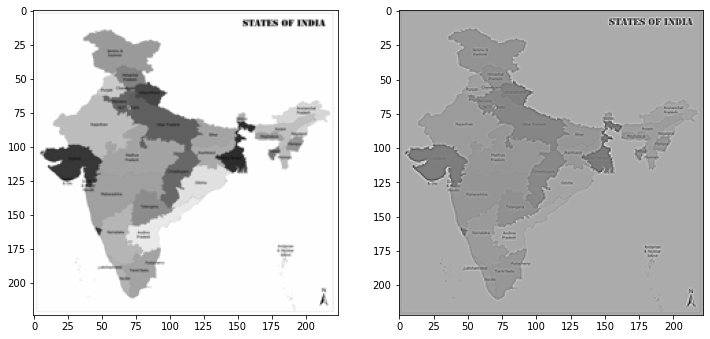

In [17]:
plot_two_images(
    img1=img, 
    img2=img_sharpened
)

The colors are a bit off since values in the right image don’t range between 0 and 255. It’s not a big issue, but you can “fix” it by replacing all negative values with zeros:

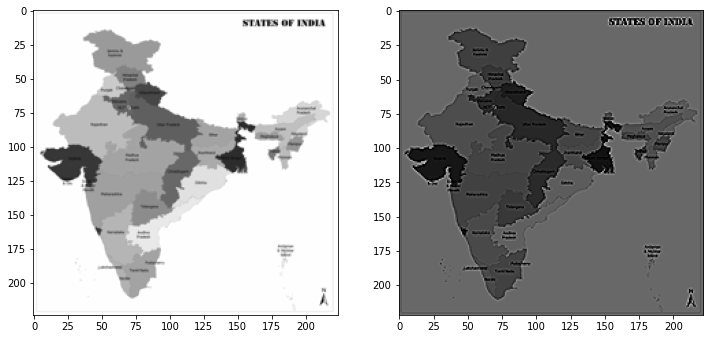

In [18]:
def negative_to_zero(img: np.array) -> np.array:
    img = img.copy()
    img[img < 0] = 0
    return img

plot_two_images(
    img1=img, 
    img2=negative_to_zero(img=img_sharpened)
)

The image on the right definitely looks sharpened, no arguing there. Let’s see what blurring does next:



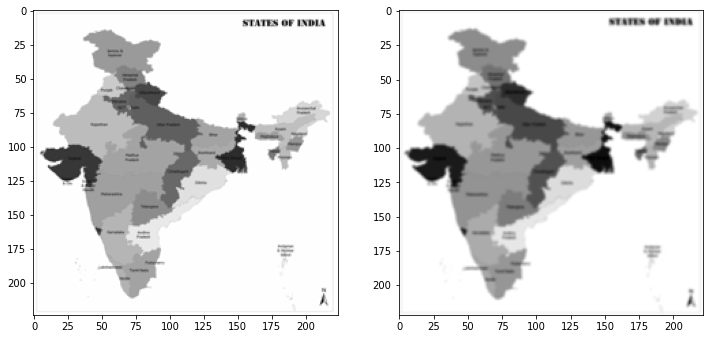

In [19]:

img_blurred = convolve(img=np.array(img), kernel=blur)
plot_two_images(
    img1=img, 
    img2=img_blurred
)

The blurring filter matrix doesn’t have negative values, so the coloring is identical. Once again, there’s no debate — the blurring filter worked as advertised.

Finally, let’s see what the outline filter will do to our image:

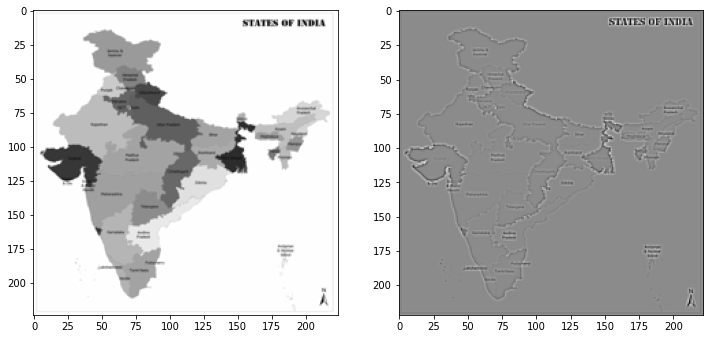

In [20]:
img_outlined = convolve(img=np.array(img), kernel=outline)
plot_two_images(
    img1=img, 
    img2=img_outlined
)

It also suffers from the coloring problem, as values in the matrix are mostly negative. Use negative_to_zero() to get a clearer idea:



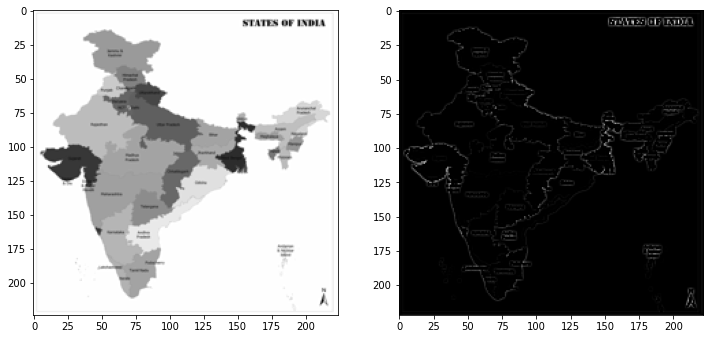

In [21]:
plot_two_images(
    img1=img, 
    img2=negative_to_zero(img=img_outlined)
)